In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
from PIL import Image

In [2]:
PATH = '/home/paperspace/data/pneumonia/'

## TODO
- all metadata in dicom
- file sizes - All train are 1024x1024 values [0,255]

In [3]:
det_class_path = f'{PATH}stage_1_detailed_class_info.csv'
bbox_path = f'{PATH}stage_1_train_labels.csv'
dicom_dir = f'{PATH}train/'

28989 class infos loaded
25684 patient cases


,patientId,class
10334,6e4e3b3c-402a-4254-82b0-f59dc70141ac,No Lung Opacity / Not Normal
1196,0f3ac29b-7682-4402-bbe5-89e4add87639,Lung Opacity
26815,eec1f97e-431a-4e44-a063-6116afc25838,No Lung Opacity / Not Normal


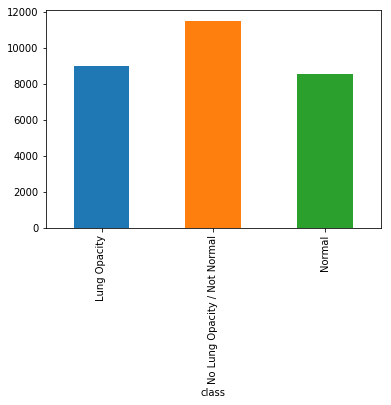

In [4]:
det_class_df = pd.read_csv(det_class_path)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

In [5]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

28989 boxes loaded
25684 patient cases


,patientId,x,y,width,height,Target
19633,b5c6d71a-3493-458c-bcb7-f174d8cdb8bc,NaN,NaN,NaN,NaN,0
260,06605bfa-0370-4979-a2bd-11173002abd1,NaN,NaN,NaN,NaN,0
82,01fdfd88-7607-48b9-ba05-a36e8b6fd19b,319.0,437.0,170.0,289.0,1


In [6]:
comb_bbox_df = pd.concat([bbox_df, 
                        det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(3)

28989 combined cases


,patientId,x,y,width,height,Target,class
18301,acf2dc69-0b5e-4600-a2c4-887c5d37438b,NaN,NaN,NaN,NaN,0,Normal
19607,b59e042d-0ec6-455a-82c8-658ccb24e614,267.0,515.0,207.0,224.0,1,Lung Opacity
14003,8b708a98-49d3-4ad8-b1bb-575d8ea43a75,NaN,NaN,NaN,NaN,0,Normal


# Distribution of Boxes and Labels
The values below show the number of boxes and the patients that have that number.

In [7]:
box_df = comb_bbox_df.groupby('patientId').\
    size().\
    reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')


,boxes,patients
0,1,22506
1,2,3062
2,3,105
3,4,11


In [8]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,8964
1,No Lung Opacity / Not Normal,0,11500
2,Normal,0,8525


In [9]:
image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

25684 images found


,BodyPartExamined,ViewPosition,PatientSex
count,25684,25684,25684
unique,1,2,2
top,CHEST,PA,M
freq,25684,13979,14593


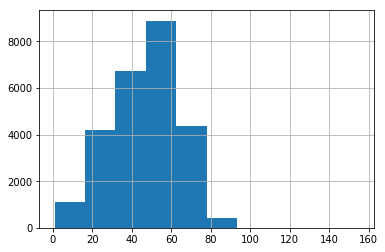

In [10]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex', 'Rows', 'Columns']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=True)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)
# show the summary
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

In [11]:
image_full_df = pd.merge(image_df,
                         image_meta_df,
                         on='path')
image_bbox_df = pd.merge(comb_box_df, 
                         image_full_df, 
                         on='patientId',
                        how='left')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.sample(10)

28989 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex,Rows,Columns
22835,cdf941f1-2904-49c1-8952-7f30476aec72,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/cdf941f1...,77,CHEST,PA,M,1024,1024
8838,62ca949a-1347-4f8f-9b62-18f2fd02538a,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/62ca949a...,62,CHEST,PA,M,1024,1024
17915,aa636938-1fb2-4d4c-9678-b703388552e7,136.0,63.0,352.0,725.0,1,Lung Opacity,2,/home/paperspace/data/pneumonia/train/aa636938...,49,CHEST,PA,M,1024,1024
8440,5f6afe5c-3287-4259-bf5a-ee49acddfdcf,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/5f6afe5c...,54,CHEST,AP,M,1024,1024
8837,62c63b51-ab42-4904-8667-a0e3cb939ebf,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/62c63b51...,33,CHEST,PA,F,1024,1024
2544,32827da4-939c-46de-85db-a2d75cb0dfad,419.0,250.0,151.0,234.0,1,Lung Opacity,2,/home/paperspace/data/pneumonia/train/32827da4...,25,CHEST,AP,M,1024,1024
16255,9da5f69a-7024-41e9-bb8c-ecd617f3c06a,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/9da5f69a...,13,CHEST,AP,M,1024,1024
26043,e8aef678-c41d-4c2b-8de6-1ebab8c6aec3,NaN,NaN,NaN,NaN,0,Normal,1,/home/paperspace/data/pneumonia/train/e8aef678...,40,CHEST,PA,M,1024,1024
5767,497f010c-5091-467a-bc3e-2c948ee696b0,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/497f010c...,58,CHEST,AP,M,1024,1024
10992,7351c984-3f01-438f-bc30-85b3a74401bb,NaN,NaN,NaN,NaN,0,Normal,1,/home/paperspace/data/pneumonia/train/7351c984...,41,CHEST,PA,M,1024,1024


In [12]:
comb_bbox_df.describe()

,x,y,width,height,Target
count,8964.000000,8964.000000,8964.000000,8964.000000,28989.000000
mean,391.456158,363.135877,220.845382,334.174364,0.309221
std,203.945378,148.607149,59.041384,158.097239,0.462180
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,205.000000,246.000000,180.000000,207.000000,0.000000
50%,320.000000,360.000000,219.000000,304.000000,0.000000
75%,591.000000,475.000000,261.000000,445.000000,1.000000
max,817.000000,881.000000,528.000000,942.000000,1.000000


In [13]:
image_bbox_df.isna().sum()

patientId               0
x                   20025
y                   20025
width               20025
height              20025
Target                  0
class                   0
boxes                   0
path                    0
PatientAge              0
BodyPartExamined        0
ViewPosition            0
PatientSex              0
Rows                    0
Columns                 0
dtype: int64

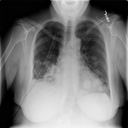

In [14]:
path = image_bbox_df.iloc[0].path
dicom = pydicom.read_file(path)
#plt.imshow(dicom.pixel_array, cmap='gray')
img = Image.fromarray(dicom.pixel_array)
img = img.resize((128,128), Image.ANTIALIAS)
img.save(f'{PATH}test.png')
img

In [15]:
dicom

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [16]:
sample_df = image_bbox_df.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex,Rows,Columns
0,a52ddada-a96e-4385-b798-8b9bf66cc3f0,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/home/paperspace/data/pneumonia/train/a52ddada...,46,CHEST,AP,M,1024,1024
1,4b57dece-117e-4f02-abf7-ee0c61bd7272,NaN,NaN,NaN,NaN,0,Normal,1,/home/paperspace/data/pneumonia/train/4b57dece...,43,CHEST,PA,F,1024,1024
2,816cef8f-cbf7-43c7-8386-609bd95c78e6,627.0,304.0,241.0,295.0,1,Lung Opacity,1,/home/paperspace/data/pneumonia/train/816cef8f...,32,CHEST,AP,F,1024,1024
3,4f7604aa-98ef-43c5-a0f4-6b4b043bd7dd,496.0,272.0,222.0,367.0,1,Lung Opacity,2,/home/paperspace/data/pneumonia/train/4f7604aa...,14,CHEST,AP,F,1024,1024
4,4f7604aa-98ef-43c5-a0f4-6b4b043bd7dd,241.0,201.0,211.0,343.0,1,Lung Opacity,2,/home/paperspace/data/pneumonia/train/4f7604aa...,14,CHEST,AP,F,1024,1024
5,e3884258-8083-4b8e-b952-9adc91a7f0f3,262.0,273.0,143.0,195.0,1,Lung Opacity,3,/home/paperspace/data/pneumonia/train/e3884258...,31,CHEST,AP,M,1024,1024
6,e3884258-8083-4b8e-b952-9adc91a7f0f3,148.0,576.0,179.0,114.0,1,Lung Opacity,3,/home/paperspace/data/pneumonia/train/e3884258...,31,CHEST,AP,M,1024,1024
7,e3884258-8083-4b8e-b952-9adc91a7f0f3,620.0,441.0,195.0,327.0,1,Lung Opacity,3,/home/paperspace/data/pneumonia/train/e3884258...,31,CHEST,AP,M,1024,1024
8,31764d54-ea3b-434f-bae2-8c579ed13799,258.0,521.0,266.0,229.0,1,Lung Opacity,4,/home/paperspace/data/pneumonia/train/31764d54...,49,CHEST,AP,F,1024,1024
9,31764d54-ea3b-434f-bae2-8c579ed13799,293.0,311.0,166.0,167.0,1,Lung Opacity,4,/home/paperspace/data/pneumonia/train/31764d54...,49,CHEST,AP,F,1024,1024


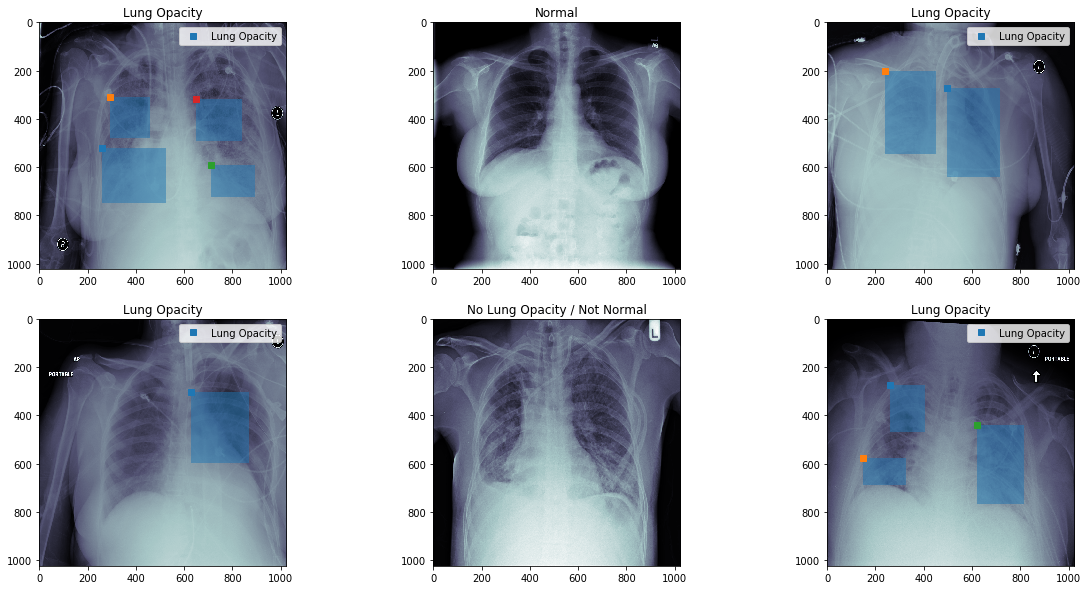

In [22]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

Bounding Box Distribution

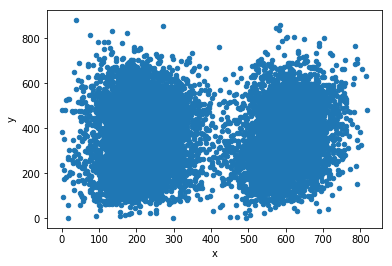

In [31]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

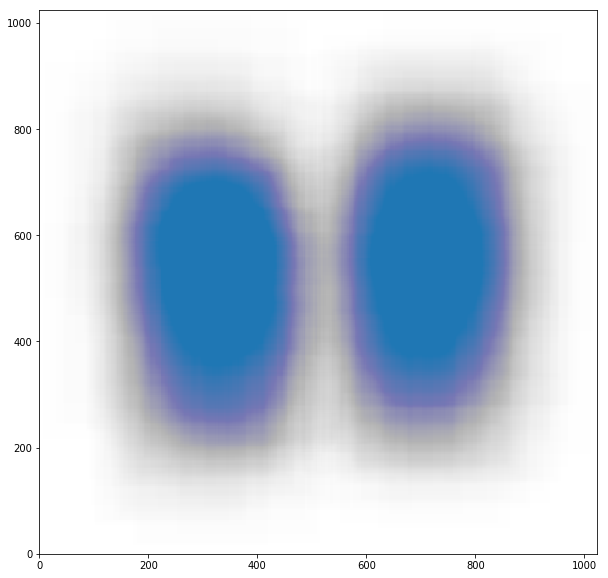

In [32]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

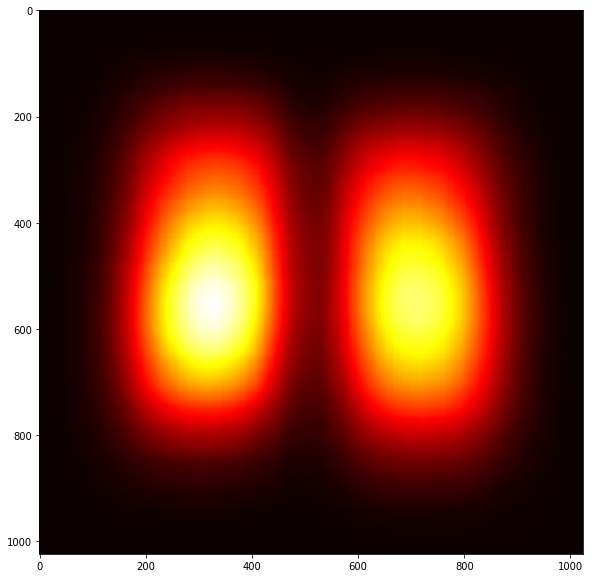

In [33]:
# Show the boxes themselves
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

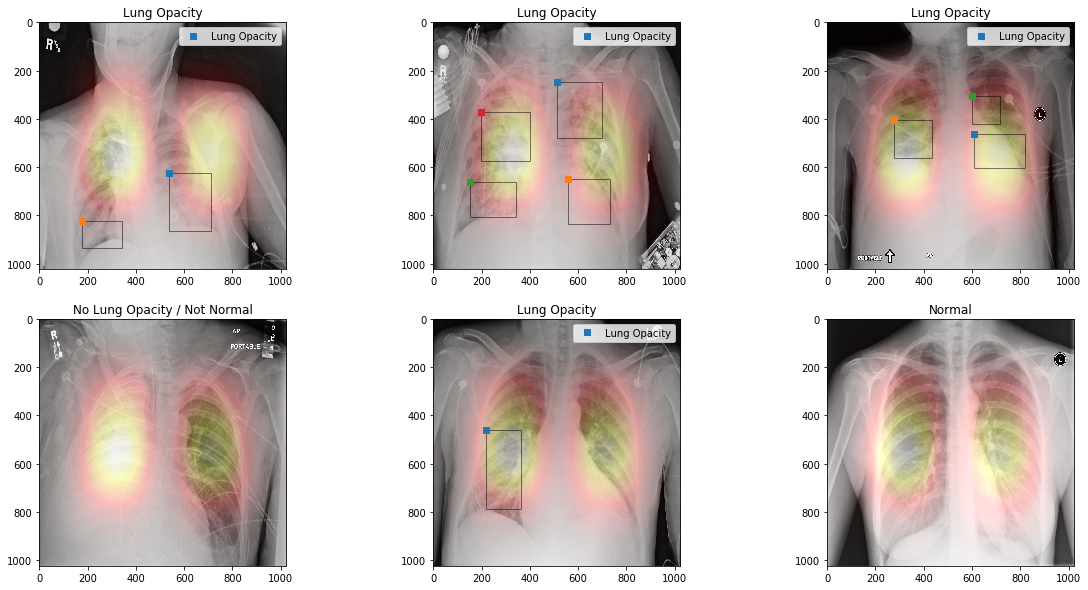

In [34]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
fig.savefig('overview.png', figdpi = 600)

In [36]:
image_bbox_df.to_csv(f'{PATH}image_bbox_full.csv', index=False)